<a href="https://colab.research.google.com/github/nicolycosta/FuncaodeCorrelacaoeCovariancia-emAndamento-/blob/main/VARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vector Autoregressive Moving-Average (VARMA)** 
 Variáveis usadas: IPVA e IGP-DI

In [ ]:
# Bibliotecas
import copy
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_percentage_error

import warnings    
warnings.filterwarnings('ignore')

In [ ]:
serie = pd.read_excel("IPVA.xlsx")
serie['Mês'] = pd.to_datetime(serie['Mês']) 
serie = serie.set_index('Mês')
serie

,IPVA,IGP-DI
Mês,,
2004-01-01,3292584.55,293.793
2004-02-01,3624237.38,296.976
2004-03-01,10141637.49,299.746
2004-04-01,7972884.99,303.184
2004-05-01,7146505.74,307.616
...,...,...
2021-05-01,79294916.85,1055.167
2021-06-01,95590000.00,1056.343
2021-07-01,83650460.45,1071.615


## **Correlação Cruzada**

In [ ]:
#### Correlação Cruzada
a= sm.tsa.stattools.ccf(serie['IGP-DI'], serie['IPVA'])
print(a[1:10])

[0.8813508  0.8677445  0.84451154 0.81208138 0.7908897  0.77627828
 0.76102182 0.75943141 0.76368572]


## **Separação em modelagem e teste**

In [ ]:
nSamples = len(serie) # Número total de amostras na série.
nTestSamples = 9     # Número de amostras definidas para teste. Nesse caso, 9 amostras.
nModelSamples = nSamples - nTestSamples     # Número de amostras definidas para modelagem
serieModel = serie.iloc[:nModelSamples]
serieTest = serie.iloc[nModelSamples:]

print(f'Número de amostras: {nSamples}')
print(f'Número de amostras para modelagem: {nModelSamples}')
print(f'Número de amostras para teste: {nTestSamples}')
print(f'Os dados de modelagem começam em {serieModel.index[0].year}-{serieModel.index[0].month} e terminam em {serieModel.index[nModelSamples - 1].year}-{serieModel.index[nModelSamples - 1].month}.')
print(f'Os dados de teste começam em {serieTest.index[0].year}-{serieTest.index[0].month} e terminam em {serieTest.index[nTestSamples - 1].year}-{serieTest.index[nTestSamples - 1].month}.')

Número de amostras: 213
Número de amostras para modelagem: 204
Número de amostras para teste: 9
Os dados de modelagem começam em 2004-1 e terminam em 2020-12.
Os dados de teste começam em 2021-1 e terminam em 2021-9.


## **Verificação de Estacionariedade**

### Função de Autocorrelação Amostral

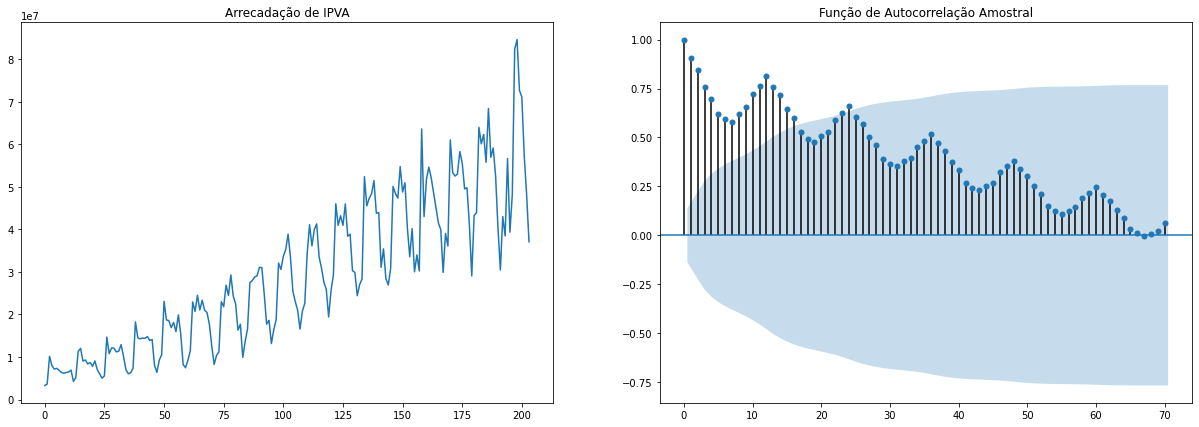

In [ ]:
#### Variável endógena: ICMS

icms = serieModel['IPVA'].values 

plt.figure(figsize = (21, 7))
plt.subplot(1,2,1)
plt.plot(icms)
plt.title('Arrecadação de IPVA')

ax2 = plt.subplot(1,2,2)
plot_acf(icms, lags=70, title = 'Função de Autocorrelação Amostral',  alpha = 0.05, ax = ax2)

plt.show()

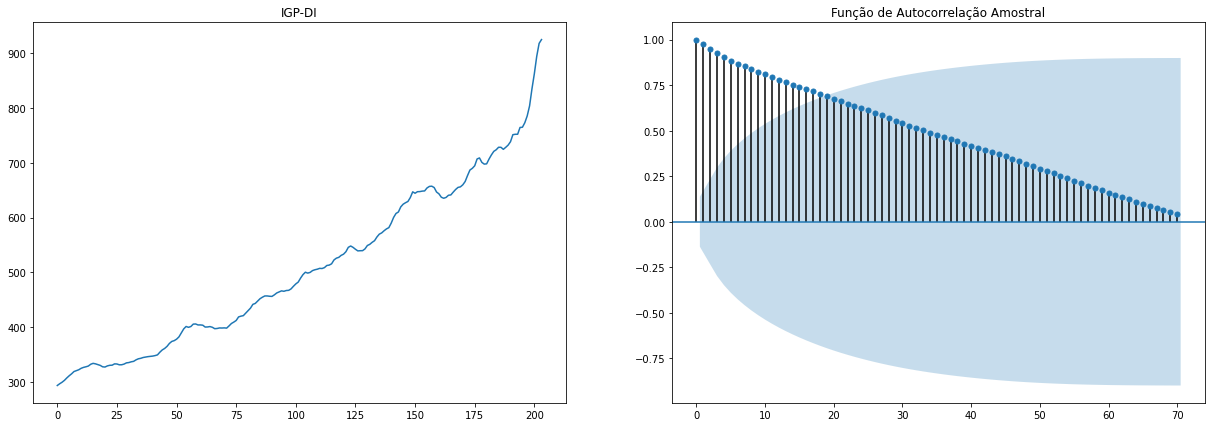

In [ ]:
#### Variável endógena: IGP-DI

ipca = serieModel['IGP-DI'].values 

plt.figure(figsize = (21, 7))
plt.subplot(1,2,1)
plt.plot(ipca)
plt.title('IGP-DI')

ax2 = plt.subplot(1,2,2)
plot_acf(ipca, lags=70, title = 'Função de Autocorrelação Amostral',  alpha = 0.05, ax = ax2)

plt.show()

### Teste Dickey-Fuller Aumentado (ADF)

In [ ]:
result = adfuller(serieModel['IPVA'].dropna(), autolag='AIC')
nSamples = len(serieModel['IPVA'].dropna())

print()
print(f'   Estatística ADF: {result[0].round(4)}')
print(f'           p-valor: {result[1].round(4)}')

print()
print(f'Resultado: A série temporal de IPVA é {"não " if result[1] > 0.05 else ""}estacionária.')
print()


   Estatística ADF: 1.4226
           p-valor: 0.9972

Resultado: A série temporal de IPVA é não estacionária.



In [ ]:
result = adfuller(serieModel['IGP-DI'].dropna(), autolag='AIC')
nSamples = len(serieModel['IGP-DI'].dropna())

print()
print(f'   Estatística ADF: {result[0].round(4)}')
print(f'           p-valor: {result[1].round(4)}')

print()
print(f'Resultado: A série temporal do IGP-DI é {"não " if result[1] > 0.05 else ""}estacionária.')
print()


   Estatística ADF: 2.4775
           p-valor: 0.999

Resultado: A série temporal do IGP-DI é não estacionária.



In [ ]:
# Claramente todas as variáveis são NÃO estacionárias e precisam de uma diferença.

## **Transformações**

In [ ]:
serieModeldiff1 = copy.copy(serieModel)
serieModeldiff1['IPVA'] = serieModeldiff1['IPVA'].diff()
serieModeldiff1['IGP-DI'] = serieModeldiff1['IGP-DI'].diff()
serieModeldiff1= serieModeldiff1.dropna()
serieModeldiff1.head(5)

,IPVA,IGP-DI
Mês,,
2004-02-01,331652.83,3.183
2004-03-01,6517400.11,2.770
2004-04-01,-2168752.50,3.438
2004-05-01,-826379.25,4.432
2004-06-01,174847.93,3.960


#### Teste Dickey-Fuller Aumentado (ADF)

In [ ]:
result = adfuller(serieModeldiff1['IPVA'].dropna(), autolag='AIC')
nSamples = len(serieModeldiff1['IPVA'].dropna())

print()
print(f'   Estatística ADF: {result[0].round(4)}')
print(f'           p-valor: {result[1].round(4)}')

print()
print(f'Resultado: A série temporal de IPVA é {"não " if result[1] > 0.05 else ""}estacionária.')
print()


   Estatística ADF: -7.5223
           p-valor: 0.0

Resultado: A série temporal de IPVA é estacionária.



In [ ]:
result = adfuller(serieModeldiff1['IGP-DI'].dropna(), autolag='AIC')
nSamples = len(serieModeldiff1['IGP-DI'].dropna())

print()
print(f'   Estatística ADF: {result[0].round(4)}')
print(f'           p-valor: {result[1].round(4)}')

print()
print(f'Resultado: A série temporal de IGP-DI é {"não " if result[1] > 0.05 else ""}estacionária.')
print()


   Estatística ADF: -4.6472
           p-valor: 0.0001

Resultado: A série temporal de IGP-DI é estacionária.



## **Diagnóstico**

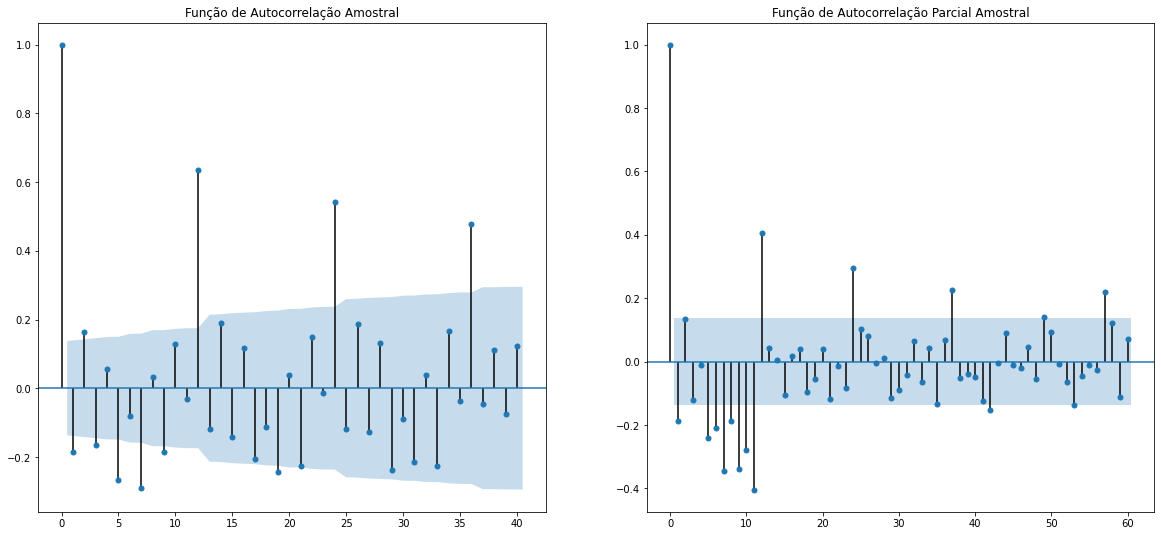

In [ ]:
plt.figure(figsize = (20, 9))


ax1 = plt.subplot(1,2,1)
plot_acf(serieModeldiff1['IPVA'], lags=40, title = 'Função de Autocorrelação Amostral', alpha = 0.05, ax = ax1)

ax2 = plt.subplot(1,2,2)
plot_pacf(serieModeldiff1['IPVA'], lags=60, title = 'Função de Autocorrelação Parcial Amostral', alpha = 0.05, ax = ax2)

plt.show()

In [ ]:
model = VARMAX(serieModeldiff1[['IPVA', 'IGP-DI']], order=(1,1))
res = model.fit(maxiter=1000) # maxiter é o número de iteração(repetição)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:     ['IPVA', 'IGP-DI']   No. Observations:                  203
Model:                     VARMA(1,1)   Log Likelihood               -4026.114
                          + intercept   AIC                           8078.228
Date:                Wed, 19 Jan 2022   BIC                           8121.300
Time:                        15:08:30   HQIC                          8095.653
Sample:                    02-01-2004                                         
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):               442.92, 41.11   Jarque-Bera (JB):        292.67, 47.50
Prob(Q):                        0.00, 0.42   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         8.33, 8.63   Skew:                       1.55, 0.28
Prob(H) (two-sided):            0.00,

## Resíduo

### Função de Autocorrelação Amostral dos resíduos

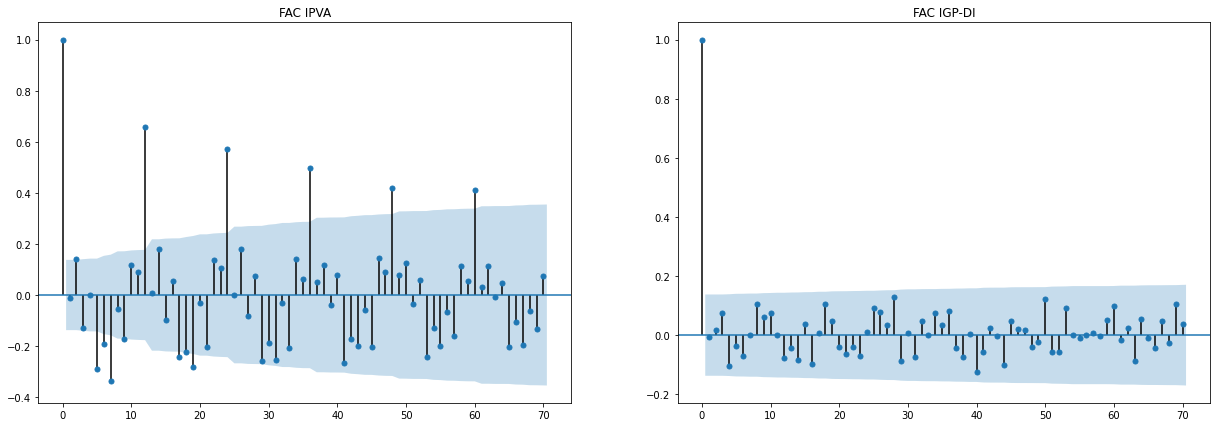

In [ ]:
plt.figure(figsize = (21, 7))
ax1= plt.subplot(1,2,1)
plot_acf(res.resid['IPVA'].values , lags=70, title = 'FAC IPVA',  alpha = 0.05, ax = ax1)
ax2 = plt.subplot(1,2,2)
plot_acf(res.resid['IGP-DI'].values, lags=70, title = 'FAC IGP-DI',  alpha = 0.05, ax = ax2)


plt.show()

## Estatística Durbin-Watson

In [ ]:
out = durbin_watson(res.resid)
out

array([2.02033622, 1.98048623])

## **Teste**

In [ ]:
model = VARMAX(serieModeldiff1[['IPVA', 'IGP-DI']], order=(6,1)) #foi feito a troca de p e q manualmente.
res = model.fit(maxiter=100) # maxiter é o número de iteração(repetição)
yhat = res.forecast(9)
#order=(5,1) 21.5
#order=(6,1) 7.9
#order=(6,2) 8.12


In [ ]:
# FUNÇÃO ALTERADA
def invert_transformation(df_train, df_forecast):
    """ Revertendo as duas diferenças """
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
            df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(serieModel,yhat)       
df_results.head(4)

,IPVA,IGP-DI,IPVA_1d,IPVA_forecast,IGP-DI_1d,IGP-DI_forecast
2021-01-01,9.641820e+06,4.981658,-1.471818e+06,4.673005e+07,11.947658,929.485658
2021-02-01,1.131108e+07,2.193037,9.839263e+06,5.804113e+07,14.140694,931.678694
2021-03-01,7.497693e+06,1.593577,1.733696e+07,6.553883e+07,15.734272,933.272272
2021-04-01,1.136993e+07,3.557561,2.870689e+07,7.690875e+07,19.291833,936.829833


### Métricas para Medição de Qualidade de Previsão

In [ ]:
mean_absolute_percentage_error(serieTest['IPVA'],df_results['IPVA_forecast'])*100

7.963373398249354

In [ ]:
mean_absolute_percentage_error(serieTest['IGP-DI'],df_results['IGP-DI_forecast'])*100

8.288575809112777

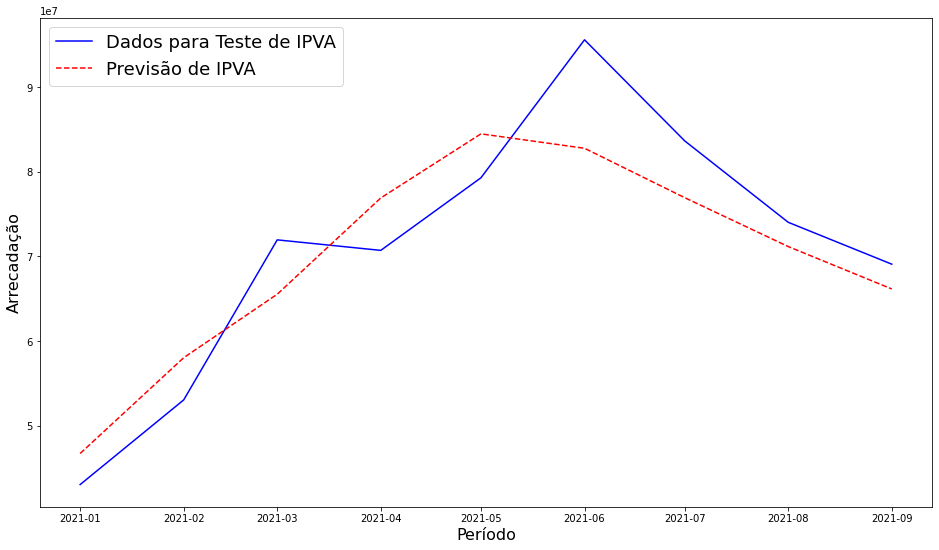

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(serieTest['IPVA'], 'b-', label = 'Dados para Teste de IPVA')
plt.plot(df_results['IPVA_forecast'], 'r--', label = 'Previsão de IPVA') 

plt.xlabel('Período',fontsize=16)
plt.ylabel('Arrecadação',fontsize=16)
plt.legend(loc = 'upper left', prop = {'size': 18})
plt.show()

## **PREVISÃO**

In [ ]:
serieM = copy.copy(serie)
serieM['IPVA'] = serieM['IPVA'].diff()
serieM['IGP-DI'] = serieM['IGP-DI'].diff()
serieM= serieM.dropna()
serieM.head(5)

,IPVA,IGP-DI
Mês,,
2004-02-01,331652.83,3.183
2004-03-01,6517400.11,2.770
2004-04-01,-2168752.50,3.438
2004-05-01,-826379.25,4.432
2004-06-01,174847.93,3.960


In [ ]:
model = VARMAX(serieM[['IPVA', 'IGP-DI']], order=(6,1)) 
res = model.fit(maxiter=100)
yhat = res.forecast(12)
df_results = invert_transformation(serie,yhat)       
df_results.head(4)



,IPVA,IGP-DI,IPVA_1d,IPVA_forecast,IGP-DI_1d,IGP-DI_forecast
2021-10-01,8.184704e+06,-3.945759,3.240162e+06,7.727258e+07,-9.782759,1060.364241
2021-11-01,-2.855125e+06,2.578573,3.850371e+05,7.441746e+07,-7.204186,1062.942814
2021-12-01,3.056012e+06,0.165108,3.441049e+06,7.747347e+07,-7.039079,1063.107921
2022-01-01,5.374704e+06,5.333430,8.815753e+06,8.284817e+07,-1.705648,1068.441352


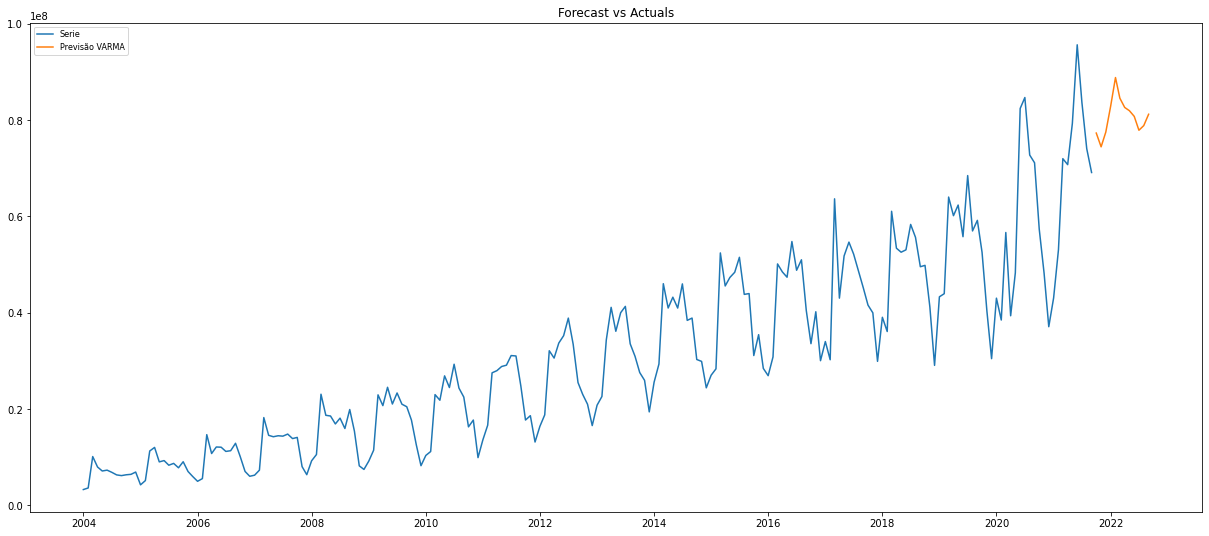

In [ ]:
# Plot
plt.figure(figsize=(21,9))
plt.plot(serie['IPVA'], label='Serie')
plt.plot(df_results['IPVA_forecast'], label='Previsão VARMA')


plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()